<a href="https://colab.research.google.com/github/Pie33000/hateful_commentary/blob/master/hateful_comment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --user -U nltk
!pip install transformers

     |████████████████████████████████| 1.4MB 11.9MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434677 sha256=81385469b5555c8cdfb3dae33fba01af35efbf6773a3c6ab1fb0548cb2d956a8
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     |████████████████████████████████| 1.3MB 10.8MB/s 
     |████████████████████████████████| 1.1MB 55.9MB/s 
     |████████████████████████████████| 890kB 57.5MB/s 
     |████████████████████████████████| 2.9MB 48.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=bfd2257e33cfb5174ae40c0203174a34cf3a8100c05788c7413e86e97b26333d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [13]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
import tensorflow as tf
import torch
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split

from transformers import BertForSequenceClassification
from transformers import AdamW
from transformers import BertTokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
df = pd.read_json("./drive/My Drive/data/train.jsonl", lines=True)

In [5]:
df.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


## Explore dataset


---


### count number of hateful comment and good comment


In [ ]:
repartition_label = df.groupby("label", as_index=False).count()[["label", "id"]]
fig = px.bar(repartition_label, x='label', y='id',
             hover_data=['label', 'id'], color='label', height=400, width=800, title="Repartition comment in two classes")
fig.show()

## Words most common in hateful comments

In [ ]:
df_hateful = df[df.label == 1].reset_index()
df_hateful["text_tokens"] = df_hateful.text.apply(lambda x: word_tokenize(x))

In [ ]:
df_hateful.text_tokens = df_hateful.text_tokens.apply(lambda x: [word for word in x if not word in stopwords.words()])

In [ ]:
df_hateful.head(1)

,index,id,img,label,text,text_tokens
0,7,70914,img/70914.png,1,tattoos are bad for your health i know 5 milli...,"[tattoos, bad, health, know, 5, million, peopl..."


In [ ]:
df_hateful.text_tokens = df_hateful.text_tokens.apply(lambda x: tf.keras.preprocessing.text.text_to_word_sequence(
    ' '.join(x), filters='!"#$%&()*+,-./:;<=>?@[\\]^_`\'{|}~\t\n', lower=True, split=' '))

In [ ]:
text_tokens = df_hateful.explode('text_tokens')["text_tokens"]

In [ ]:
ps = nltk.PorterStemmer()

In [ ]:
text_tokens = text_tokens.apply(lambda x: ps.stem(str(x)))

In [ ]:
df_hateful_words = pd.DataFrame(text_tokens, columns=["text_tokens"])
df_hateful_words["count"] = 0
df_hateful_words = df_hateful_words[df_hateful_words.text_tokens.str.len() > 2]
words_count = df_hateful_words.groupby("text_tokens", as_index=False).count()

In [ ]:
words_count.sort_values("count", ascending=False, inplace=True)
words_count = words_count[:50]
fig = px.bar(words_count, x='text_tokens', y='count',
             hover_data=['text_tokens', 'count'], color='count', height=500, width=1000, title="Most common word in hateful comments")
fig.show()

## Words most common in good comments

In [ ]:
df_good = df[df.label == 0].reset_index()
df_good["text_tokens"] = df_good.text.apply(lambda x: word_tokenize(x))
df_good.text_tokens = df_good.text_tokens.apply(lambda x: [word for word in x if not word in stopwords.words()])

In [ ]:
df_good.head(1)

,index,id,img,label,text,text_tokens
0,0,42953,img/42953.png,0,its their character not their color that matters,"[character, color, matters]"


In [ ]:
df_good.text_tokens = df_good.text_tokens.apply(lambda x: tf.keras.preprocessing.text.text_to_word_sequence(
    ' '.join(x), filters='!"#$%&()*+,-./:;<=>?@[\\]^_`\'{|}~\t\n', lower=True, split=' '))

In [ ]:
text_tokens_good = df_good.explode('text_tokens')["text_tokens"]

In [ ]:
text_tokens_good = text_tokens_good.apply(lambda x: ps.stem(str(x)))

In [ ]:
df_good_words = pd.DataFrame(text_tokens_good, columns=["text_tokens"])
df_good_words["count"] = 0
df_good_words = df_good_words[df_good_words.text_tokens.str.len() > 2]
words_count_good = df_good_words.groupby("text_tokens", as_index=False).count()

In [ ]:
words_count_good.sort_values("count", ascending=False, inplace=True)
words_count_good = words_count_good[:50]
fig = px.bar(words_count_good, x='text_tokens', y='count',
             hover_data=['text_tokens', 'count'], color='count', height=500, width=1000, title="Most common word in good comments")
fig.show()

## N-GRAMS in hateful comments

In [ ]:
df_hateful = df[df.label == 1].reset_index()
df_hateful["text_tokens"] = df_hateful.text.apply(lambda x: word_tokenize(x))
df_hateful.text_tokens = df_hateful.text_tokens.apply(lambda x: [word for word in x if not word in stopwords.words()])

In [ ]:
df_hateful.text_tokens = df_hateful.text_tokens.apply(lambda x: tf.keras.preprocessing.text.text_to_word_sequence(
    ' '.join(x), filters='!"#$%&()*+,-./:;<=>?@[\\]^_`\'{|}~\t\n', lower=True, split=' '))

In [ ]:
df_hateful.text_tokens = df_hateful.text_tokens.apply(lambda x: list(nltk.ngrams(x, 2)))
df_hateful = df_hateful.explode("text_tokens")

In [ ]:
df_hateful_2gramns = df_hateful.groupby("text_tokens",as_index=False).count().sort_values("index", ascending=False)[["text_tokens", "id"]]
df_hateful_2gramns = df_hateful_2gramns.rename(columns={"id": "count"})[:50]

In [ ]:
df_hateful_2gramns["index"] = np.arange(len(df_hateful_2gramns))

Text(0.5, 1.0, 'Most common 2-Grams in hateful comments')

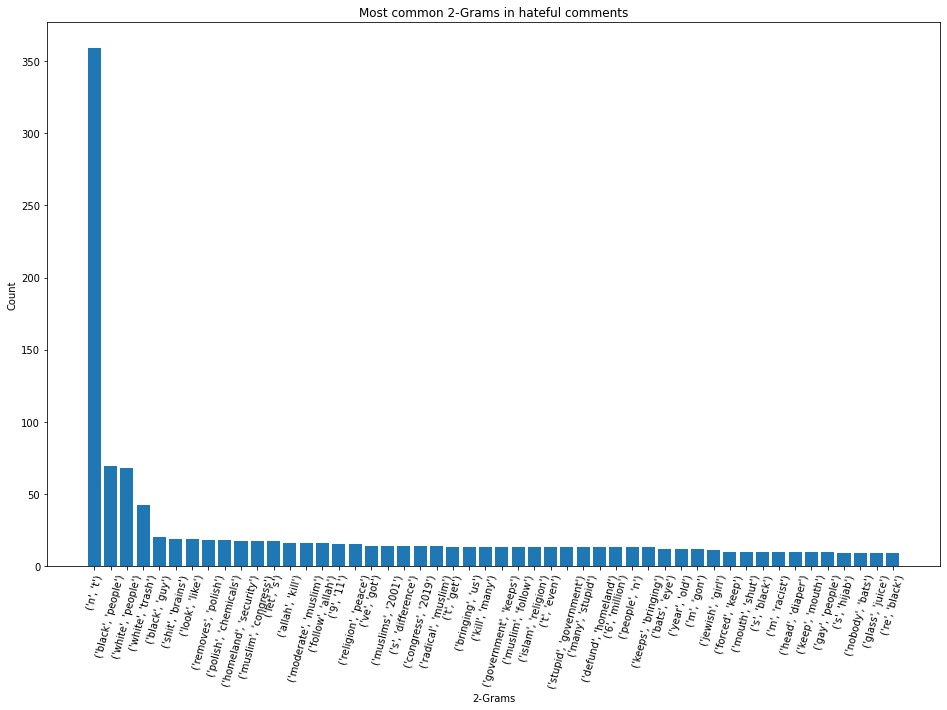

In [ ]:
plt.figure(figsize=(16, 10))
plt.bar(df_hateful_2gramns["index"], df_hateful_2gramns["count"])
plt.xticks(df_hateful_2gramns["index"], df_hateful_2gramns["text_tokens"], rotation=75)
plt.xlabel("2-Grams")
plt.ylabel("Count")
plt.title("Most common 2-Grams in hateful comments")

## N-GRAMS in good comments

In [ ]:
df_good = df[df.label == 0].reset_index()
df_good["text_tokens"] = df_good.text.apply(lambda x: word_tokenize(x))
df_good.text_tokens = df_good.text_tokens.apply(lambda x: [word for word in x if not word in stopwords.words()])

In [ ]:
df_good.text_tokens = df_good.text_tokens.apply(lambda x: tf.keras.preprocessing.text.text_to_word_sequence(
    ' '.join(x), filters='!"#$%&()*+,-./:;<=>?@[\\]^_`\'{|}~\t\n', lower=True, split=' '))

In [ ]:
df_good.text_tokens = df_good.text_tokens.apply(lambda x: list(nltk.ngrams(x, 2)))
df_good = df_good.explode("text_tokens")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

generator 'ngrams' raised StopIteration



In [ ]:
df_good_2gramns = df_good.groupby("text_tokens",as_index=False).count().sort_values("index", ascending=False)[["text_tokens", "id"]]

In [ ]:
df_good_2gramns = df_good_2gramns.rename(columns={"id": "count"})

Text(0.5, 1.0, 'Most common 2-Grams in good comments')

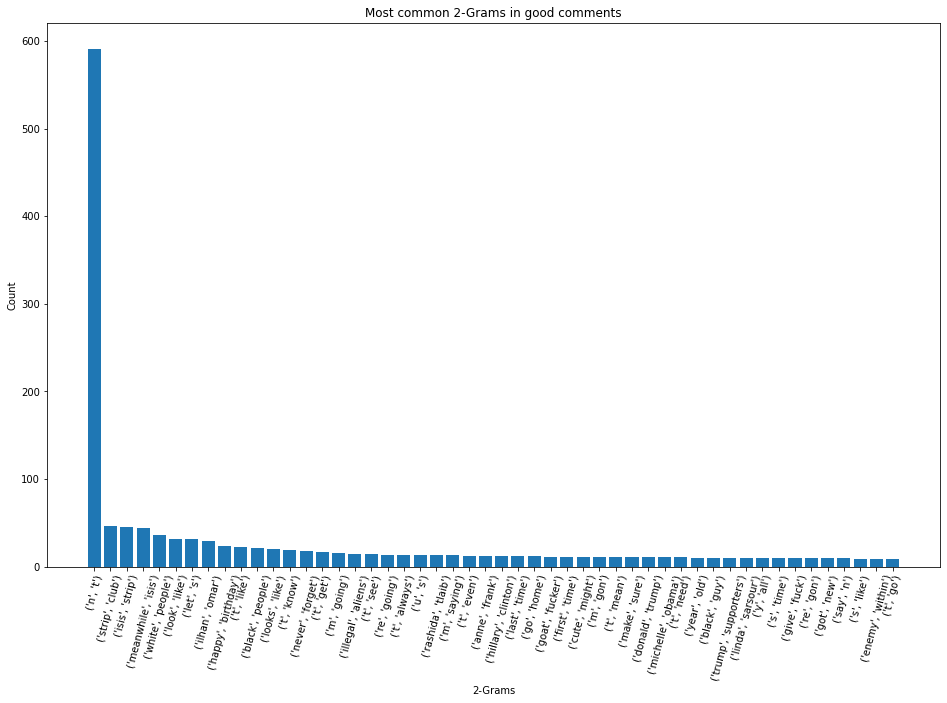

In [ ]:
df_good_2gramns["index"] = np.arange(len(df_good_2gramns))
df_good_2gramns = df_good_2gramns[:50]
plt.figure(figsize=(16, 10))
plt.bar(df_good_2gramns["index"], df_good_2gramns["count"])
plt.xticks(df_good_2gramns["index"], df_good_2gramns["text_tokens"], rotation=75)
plt.xlabel("2-Grams")
plt.ylabel("Count")
plt.title("Most common 2-Grams in good comments")

## Text sentiment to analyze sentiment of piece of text

In [7]:
df = df.sample(frac=1).reset_index(drop=True)

In [10]:
len(df)

8500

In [12]:
df[8400:]

,id,img,label,text
8400,2971,img/02971.png,1,what do you get when you cross harvey price wi...
8401,15267,img/15267.png,1,why do muslims were towels on their heads so i...
8402,50614,img/50614.png,0,clint eastwood and a monkey
8403,59364,img/59364.png,0,how a black woman can fight crime
8404,67325,img/67325.png,0,bombbbssss awayyyyyy
...,...,...,...,...
8495,84970,img/84970.png,1,retarded you are kill yourself u must
8496,15948,img/15948.png,0,that awkward moment when there's no candy in t...
8497,30251,img/30251.png,0,so i guess a handjob is out of the question
8498,96708,img/96708.png,0,even casey anthony cared enough about her daug...


In [14]:
def train(df, batch_size, n_iter=100):
  # define model
  model = BertForSequenceClassification.from_pretrained('bert-base-uncased', return_dict=True)
  model.train()
  optimizer = AdamW(model.parameters(), lr=1e-5)
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

  #fine tune
  for iter in range(n_iter):
    for i in range(0, len(df), batch_size):
      end_index = i + batch_size
      if end_index > len(df):
        batch = df[i:]
      else:
        batch = df[i:end_index]
      text_batch = batch["text"].values.tolist()
      encoding = tokenizer(text_batch, return_tensors='pt', padding=True, truncation=True)
      input_ids = encoding['input_ids']
      attention_mask = encoding['attention_mask']

      labels = torch.tensor(batch.label.values).unsqueeze(0)

      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
    if iter % 10 == 0:
      print("iter: {}, loss: {}".format(i, loss))
  return model

In [ ]:
fine_tuned_model = train(df, 100)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
result = outputs[1].detach().numpy()

In [ ]:
result_label = []
for i in range(len(result)):
  if result[i][0] > result[i][1]:
    result_label.append(0)
  else:
    result_label.append(1)

In [ ]:
cpt = 0
for i in labels.numpy()[0]:
  if i == 1:
    cpt += 1

In [ ]:
tp = 0
tn = 0
fp = 0
labels_numpy = labels.numpy()[0].tolist()
for i in range(len(result_label)):
  if int(result_label[i]) == int(labels_numpy[i]) and int(result_label[i]) == 0:
    tn += 1
  if int(result_label[i]) == int(labels_numpy[i]) and int(result_label[i]) == 1:
    tp += 1
  if int(result_label[i]) != int(labels_numpy[i]) and int(result_label[i]) == 0:
    fp += 1

In [ ]:
print("Recall: ", tp / cpt)

Recall:  0.06060606060606061


In [ ]:
print("FP: ", fp)

FP:  31
